In [14]:
import sys
# !{sys.executable} -m pip install ta

import pandas as pd
import requests
from datetime import datetime
from matplotlib import pyplot as plt
import ta
import os
from scipy.stats import linregress
from scipy.optimize import curve_fit


In [15]:
# https://rapidapi.com/apidojo/api/yahoo-finance1
# https://rapidapi.com/blog/yahoo-finance-api-python/

# soybean = ZSX21.CBT, corn ="ZCU21.CBT", John Deere = "DE"
url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/market/get-charts"
stock = "^IXIC"

time = "max"
#querystring = {"region":"US","q":"DE"}
#  range are 1D, 5D, 1M, 6M, YTD, 1y, 5y, Max  I think are lower case

# you will need to get your own API key from Yahoo Finance!!!!!
querystring = {"region":"US","comparisons":"%5EGDAXI%2C%5EFCHI","symbol":stock,"interval":"1d","range":time}
headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': "4d2c077d41msh95da52fee493f7dp1ebd33jsn6c54e77470cc"
    }

#def fetchStockData(symbol):
response = requests.request("GET", url, headers=headers, params=querystring).json() # similar to dic in python
import datetime as dt
last_update = str(dt.date.today())


In [16]:
# print JSON in muy buinito
import json
json_string = json.dumps(response,  
                         skipkeys = False,  
                         allow_nan = True, 
                         indent = 4) 

# response["chart"]["result"][0]["meta"]["currency"]
timestamp = response["chart"]["result"][0]["timestamp"]
open1 = response["chart"]["result"][0]["indicators"]["quote"][0]["open"]
high = response["chart"]["result"][0]["indicators"]["quote"][0]["high"]
low = response["chart"]["result"][0]["indicators"]["quote"][0]["low"]
close = response["chart"]["result"][0]["indicators"]["quote"][0]["close"]
volume = response["chart"]["result"][0]["indicators"]["quote"][0]["volume"]

#print(json_string)
df = pd.DataFrame({"timestamp":timestamp,"open":open1,"low":low,"high":high,"close":close,"volume":volume})
# df.to_csv(f"Output/{stock}fileOne.csv", index = False, header=True)

In [17]:
# Convert UTC date time to standard day month year format and remove holidays
df['date_time'] = [datetime.utcfromtimestamp(d) for d in df['timestamp']] # utcfromtimestamp for accurate date
df['date'] = [datetime.date(d) for d in df['date_time']]
df.dropna(subset = ["open"], inplace=True)# drop rows with no data, i.e. holidays
# df.to_csv("Output/Deere.csv", index = False, header=True)
df

,timestamp,open,low,high,close,volume,date_time,date
0,34232400,100.000000,99.680000,112.459999,112.300003,0.000000e+00,1971-02-01 05:00:00,1971-02-01
1,41918400,111.349998,105.269997,111.769997,105.269997,0.000000e+00,1971-05-01 04:00:00,1971-05-01
2,49867200,105.589996,103.040001,110.980003,105.099998,0.000000e+00,1971-08-01 04:00:00,1971-08-01
3,57819600,103.690002,100.309998,118.870003,118.870003,0.000000e+00,1971-11-01 05:00:00,1971-11-01
4,65768400,119.580002,119.580002,134.100006,131.330002,0.000000e+00,1972-02-01 05:00:00,1972-02-01
...,...,...,...,...,...,...,...,...
196,1580533200,9190.719727,6631.419922,9838.370117,8889.549805,2.292051e+11,2020-02-01 05:00:00,2020-02-01
197,1588305600,8681.290039,8537.830078,10839.929688,10745.269531,2.821242e+11,2020-05-01 04:00:00,2020-05-01
198,1596254400,10848.639648,10519.490234,12074.059570,10911.589844,2.382948e+11,2020-08-01 04:00:00,2020-08-01
199,1604203200,11010.450195,10830.950195,12973.330078,12888.280273,2.023057e+11,2020-11-01 04:00:00,2020-11-01


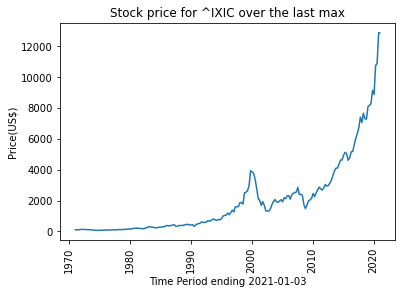

In [18]:
x = df['date']  # date makes no big changes from date_time
y = df['close']
plt.xticks(rotation=90)
plt.title(f"Stock price for {stock} over the last {time}")
plt.ylabel("Price(US$)")
plt.xlabel(f"Time Period ending {last_update}")
# file_name = f"Images/{stock}vs{time}.png"
plt.plot(x,y)


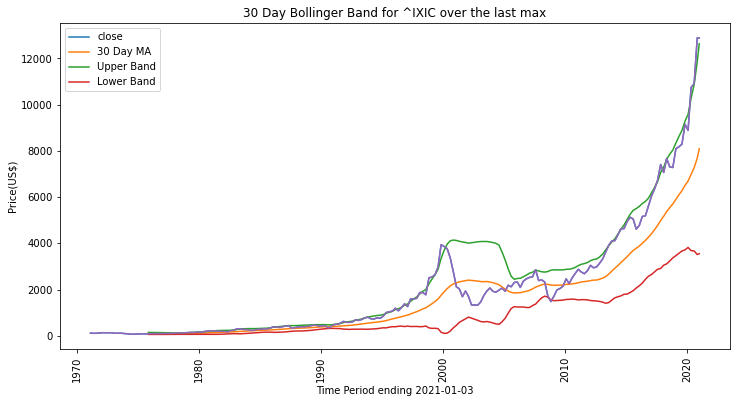

In [19]:
# bollinger bands   https://medium.com/python-data/setting-up-a-bollinger-band-with-python-28941e2fa300
# Calculate 30 Day Moving Average, Std Deviation, Upper Band and Lower Band
df['30 Day MA'] = df['close'].rolling(window=20).mean()
df['30 Day STD'] = df['close'].rolling(window=20).std() 
df['Upper Band'] = df['30 Day MA'] + (df['30 Day STD'] * 2)
df['Lower Band'] = df['30 Day MA'] - (df['30 Day STD'] * 2)

df.set_index('date',inplace = True)
# Simple 30 Day Bollinger Band
df[['close', '30 Day MA', 'Upper Band', 'Lower Band']].plot(figsize=(12,6))
plt.title(f"30 Day Bollinger Band for {stock} over the last {time}")
plt.ylabel("Price(US$)")
plt.xlabel(f"Time Period ending {last_update}")
plt.xticks(rotation=90)
file_name = f"Images/Bollinger{stock}vs{time}.png"
plt.plot(x,y)


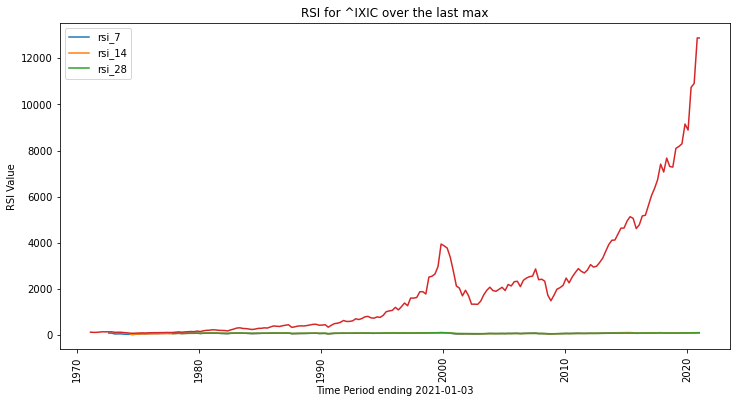

In [20]:
# class ta.momentum.RSIIndicator(close: pandas.core.series.Series, n: int = 14, fillna: bool = False)
rsi_14 = ta.momentum.RSIIndicator(df["close"], n = 14)
rsi_7 = ta.momentum.RSIIndicator(df["close"], n = 7)
rsi_28 = ta.momentum.RSIIndicator(df["close"], n = 28)
df["rsi_7"] = rsi_7.rsi()
df["rsi_14"] = rsi_14.rsi()
df["rsi_28"] = rsi_28.rsi()
df[['rsi_7', 'rsi_14', 'rsi_28']].plot(figsize=(12,6))
plt.title(f"RSI for {stock} over the last {time}")
plt.ylabel("RSI Value")
plt.xlabel(f"Time Period ending {last_update}")
plt.xticks(rotation=90)
file_name = f"Images/RSI{stock}vs{time}.png"
plt.plot(x,y)

In [21]:
x_array = df['timestamp']
y_array = df['close']


In [23]:
# ## Plotting the exponetial data
# =3.4362*EXP(0.000205*B2)
# #  Reference https://github.com/emilyripka/BlogRepo/blob/master/181113_CurveFitting.ipynb
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
# http://justinbois.github.io/bootcamp/2018/lessons/l34_regressions.html

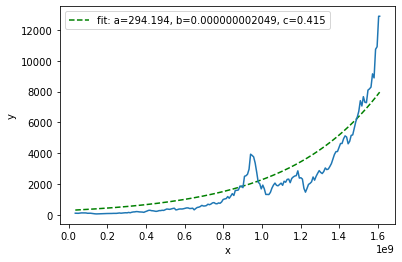

In [25]:
import numpy as np

# define a fitting function called exponentail which takes
# in the x-data (x) and returns an exponential curve with equation
# a*exp(x*k) which best fits the data
def func(x, a, b, c):
    return a * np.exp(b * x) + c

# xdata = np.linspace(0, 4, 50)
# y = func(xdata, 2.5, 1.3, 0.5)
# np.random.seed(1729)
# y_noise = 0.2 * np.random.normal(size=xdata.size)
# ydata = y + y_noise
# plt.plot(xdata, ydata, 'b-', label='data')


# popt, pcov = curve_fit(func, xdata, ydata)
# popt
# array([ 2.55423706,  1.35190947,  0.47450618])
# plt.plot(xdata, func(xdata, *popt), 'r-',
#          label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))


popt, pcov = curve_fit(func, x_array, y_array, bounds=(0, [317, .000000002062, 1]))
popt
plt.plot(x_array, func(x_array, *popt), 'g--',
         label='fit: a=%5.3f, b=%5.12f, c=%5.3f' % tuple(popt))
plt.plot(x_array, y)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [14]:
# Dow Jones Industrial average with regression

x = DJI['Date']
y = DJI['Close']

#  !!!  need to calculate line regression with date. Date is 
# currently a string   !!!!
print(x)
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")

plt.title(f"Dow Jones Industial Average since 1985")
plt.ylabel("Value Value")
plt.xlabel(f"Time Period ending Nov 20, 2020")
plt.xticks(rotation=90)
file_name = f"Images/DJImodel.png"
plt.plot(x,y)
# plt.savefig(file_name)

0         2/1/1985
1         2/4/1985
2         2/5/1985
3         2/6/1985
4         2/7/1985
           ...    
9021    11/16/2020
9022    11/17/2020
9023    11/18/2020
9024    11/19/2020
9025    11/20/2020
Name: Date, Length: 9026, dtype: object
